In [138]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import VotingRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn import ensemble
from sklearn import svm
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier

import optuna

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [64]:
def read_data(filename):
    data = pd.read_csv(filename)
    target = data['Cholesterol Total (mg/dL)']
    data.drop(['Responden', 'Cholesterol Total (mg/dL)'], axis=1, inplace=True)
    data["Jenis Kelamin"] = data["Jenis Kelamin"].apply(lambda x: 1 if x == 'M' else 0)
    return data, target

In [160]:
data2, target2 = read_data('data.csv')
data2.drop('Tempat lahir', axis=1, inplace=True)

In [199]:
class DSCModel:
    def __init__(self):
        self.__classifier = XGBClassifier()
        self.__regressor = RandomForestRegressor()    

    def fit(self, X, y):
        from xgboost import plot_importance
        target = y.apply(lambda x: 1 if x == 187 else 0)
        self.__classifier.fit(X, target)
        x_filtered, y_filtered = X[target == 0], y[target == 0]
        print(len(x_filtered))
        self.__regressor.fit(x_filtered, y_filtered)
        model = self.__regressor
        #plt.title('Feature Importance Classifier')
        #plot_importance(model)

    def predict(self, X):
        pred_187 = self.__classifier.predict(X)
        not_187 = X[pred_187 == 0]
        pred = self.__regressor.predict(not_187)
        pred = np.round(pred)
        result = []
        idx1, idx2 = 0, 0
        while idx1 + idx2 < len(X):
            if pred_187[idx1 + idx2]:
                result.append(187)
                idx1 += 1
            else:
                result.append(pred[idx2])
                idx2 += 1
        return result

In [193]:
def perform_cross_validation(model, X, y, num_folds):
    # Initialize KFold with stratified sampling
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    
    # Initialize list to store RMSE scores for each fold
    rmse_scores = []
    accuracy = []

    # Perform k-fold cross-validation
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        counter = y_pred - np.array(y_test)
        
        counter = len([elm for elm in counter if elm == 0])
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        accuracy.append(counter/len(y_test))
        # Append RMSE to the list of scores
        rmse_scores.append(rmse)

    #print(f'{model.__class__.__name__}')
    print(f'RMSE = {np.mean(rmse_scores)}')
    #print(f'Accuracy = {accuracy}, {np.mean(accuracy)}')

In [139]:
perform_cross_validation(DSCModel(), data2, target2, 5)

DSCModel
RMSE = [22.181745890399807, 20.63144969259093, 20.212213686025393, 17.21635806651996, 20.11036962097253], 20.070427391301724
Accuracy = [0.5895522388059702, 0.5783582089552238, 0.585820895522388, 0.582089552238806, 0.5955056179775281], 0.5862653026999831


Data 1 Untuk Ngecek
----

549


29.942959471598797

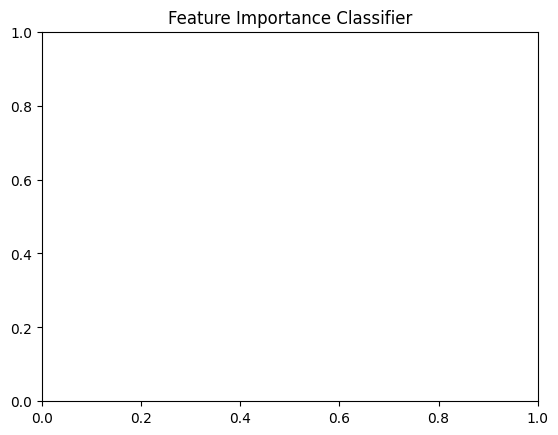

In [198]:
data1, target1 = read_data('data1.csv')
model = DSCModel()
model.fit(data2, target2)
pred1 = model.predict(data1)
np.sqrt(mean_squared_error(pred1, target1))

In [187]:
data2[target2 == 187]['Usia'].value_counts()

Usia
24.0    102
27.0    102
26.0     99
29.0     92
25.0     92
23.0     91
28.0     90
22.0     40
30.0     29
21.0     20
20.0      8
31.0      5
19.0      5
32.0      3
37.0      3
38.0      3
34.0      2
36.0      2
33.0      1
39.0      1
Name: count, dtype: int64

In [190]:
data2[target2 != 187]['Usia'].value_counts()

Usia
30.0    60
31.0    59
33.0    50
39.0    49
38.0    43
32.0    40
35.0    36
34.0    35
36.0    35
37.0    26
28.0    22
26.0    19
29.0    19
27.0    17
24.0    13
25.0    11
23.0    11
22.0     3
20.0     1
Name: count, dtype: int64

In [71]:
perform_cross_validation(DSCModel(), data1, target1, 5)
perform_cross_validation(RandomForestRegressor(), data1, target1, 5)

DSCModel
RMSE = [35.774215862097456, 30.126900553928568, 24.615119532292365, 33.23659478461523, 32.0248191422823], 31.155529975043187
Accuracy = [0.0, 0.0, 0.0, 0.0136986301369863, 0.0], 0.0027397260273972603
RandomForestRegressor
RMSE = [35.774555241675976, 30.021456801646895, 25.352500943883012, 33.445336407296914, 31.92052399405114], 31.302874677710786
Accuracy = [0.0, 0.0, 0.0, 0.0, 0.0], 0.0


In [84]:
perform_cross_validation(DSCModel(), data2, target2, 5)
perform_cross_validation(RandomForestRegressor(), data2, target2, 5)

DSCModel
RMSE = [18.592046124740484, 18.845404047972632, 19.010994462356805, 21.312003484827827, 21.674818403137518], 19.887053304607054
Accuracy = [0.5932835820895522, 0.6007462686567164, 0.6194029850746269, 0.6082089552238806, 0.5243445692883895], 0.5891972720666331
RandomForestRegressor
RMSE = [18.50085427636313, 18.971586295488425, 20.06208147375794, 21.30002181871211, 21.97823029991507], 20.162554832847334
Accuracy = [0.39552238805970147, 0.3619402985074627, 0.3880597014925373, 0.4253731343283582, 0.34831460674157305], 0.3838420258259265


In [146]:
rf = RandomForestRegressor()
rf.fit(data2, target2)
preds_rf = rf.predict(data1)
np.sqrt(mean_squared_error(preds_rf, target1))

29.070179391655184

In [147]:
xgb = XGBRegressor()
xgb.fit(data2, target2)
preds_xgb = xgb.predict(data1)
np.sqrt(mean_squared_error(preds_xgb, target1))

37.28706616598369

In [155]:
dsc = DSCModel()
dsc.fit(data2, target2)
pred_dsc = dsc.predict(data1)
np.sqrt(mean_squared_error(pred_dsc, target1))

Jenis Kelamin 0.026638794921014414
Usia 0.07993227011395555
Tekanan darah  (S) 0.04535770459619676
Tekanan darah  (D) 0.032521180930415776
Tinggi badan (cm) 0.09633375912998103
Berat badan (kg) 0.07705412521378628
IMT (kg/m2) 0.09079536928162951
Lingkar perut (cm) 0.06932022002533768
Glukosa Puasa (mg/dL) 0.04810351621311492
Trigliserida (mg/dL) 0.25668519140744583
Fat 0.041010643967693584
Visceral Fat 0.036067838838955424
Masa Kerja 0.1001793853604731


30.400657887618156

In [95]:
print(set(target1.unique()) - set(target2.unique()))

{320.0, 131.0, 132.0, 292.0, 263.0, 233.0, 265.0, 267.0, 239.0, 276.0, 277.0, 246.0, 280.0, 283.0, 254.0}


In [94]:
print(set(target2.unique()) - set(target1.unique()))

{257.0, 260.0, 261.0, 262.0, 137.0, 266.0, 139.0, 140.0, 141.0, 142.0, 143.0, 145.0, 147.0, 149.0, 279.0, 171.0, 304.0, 308.0, 247.0, 227.0, 103.0, 104.0, 251.0, 114.0, 242.0, 118.0, 119.0, 120.0, 122.0, 123.0}


In [96]:
print(set(target1.unique()).intersection(set(target2.unique())))

{127.0, 130.0, 133.0, 134.0, 135.0, 136.0, 138.0, 144.0, 146.0, 148.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0, 156.0, 157.0, 158.0, 159.0, 160.0, 161.0, 162.0, 163.0, 164.0, 165.0, 166.0, 167.0, 168.0, 169.0, 170.0, 172.0, 173.0, 174.0, 175.0, 176.0, 177.0, 178.0, 179.0, 180.0, 181.0, 182.0, 183.0, 184.0, 185.0, 186.0, 187.0, 188.0, 189.0, 190.0, 191.0, 192.0, 193.0, 194.0, 195.0, 196.0, 197.0, 198.0, 199.0, 200.0, 201.0, 202.0, 203.0, 204.0, 205.0, 206.0, 207.0, 208.0, 209.0, 210.0, 211.0, 212.0, 213.0, 214.0, 215.0, 216.0, 217.0, 218.0, 219.0, 220.0, 221.0, 222.0, 223.0, 224.0, 225.0, 226.0, 228.0, 229.0, 230.0, 231.0, 232.0, 234.0, 235.0, 236.0, 237.0, 238.0, 240.0, 241.0, 243.0, 244.0, 245.0, 248.0, 249.0, 250.0, 253.0, 255.0, 256.0, 264.0, 268.0, 269.0, 270.0, 271.0, 275.0, 282.0}


In [212]:
def read_data_without_187(filename):
    data = pd.read_csv(filename)
    data = data[data['Cholesterol Total (mg/dL)'] != 187]
    target = data['Cholesterol Total (mg/dL)']
    data.drop(['Responden', 'Cholesterol Total (mg/dL)'], axis=1, inplace=True)
    data["Jenis Kelamin"] = data["Jenis Kelamin"].apply(lambda x: 1 if x == 'M' else 0)
    return data, target

In [213]:
data3, target3 = read_data_without_187('data.csv')
data3.drop('Tempat lahir', axis=1, inplace=True)
rf = RandomForestRegressor()
rf.fit(data3, target3)
preds1 = rf.predict(data1)
np.sqrt(mean_squared_error(preds1, target1))

29.97050846305826

In [214]:
# Define the models
models = [
    XGBRegressor(),
    #CatBoostRegressor(verbose=False),
    LGBMRegressor(),
    RandomForestRegressor(),
    LinearRegression(),
    Ridge(),
    Lasso(),
    LogisticRegression(),
]

print("=" * 50 + " Tanpa Drop " + "=" * 50)
for model in models:
    perform_cross_validation(model, data3, target3, 5)

================================================== Tanpa Drop ==================================================
XGBRegressor
RMSE = 32.55845011260976
LGBMRegressor
RMSE = 32.53727556023499
RandomForestRegressor
RMSE = 31.537360631304864
LinearRegression
RMSE = 32.2936294706871
Ridge
RMSE = 32.28843252235978
Lasso
RMSE = 32.26098747866248
LogisticRegression
RMSE = 39.77495361746239


In [221]:
feat_drop = ['Lingkar perut (cm)', 'IMT (kg/m2)', 'Glukosa Puasa (mg/dL)', 'Visceral Fat', 'Fat', 'Jenis Kelamin']
from itertools import combinations
for count in range(1, 7):
    for feat in combinations(feat_drop, count):
        print(list(feat))
        perform_cross_validation(RandomForestRegressor(), data3, target3, 5)

['Lingkar perut (cm)']
RandomForestRegressor
RMSE = 31.486769722981172
['IMT (kg/m2)']
RandomForestRegressor
RMSE = 31.389302657363583
['Glukosa Puasa (mg/dL)']
RandomForestRegressor
RMSE = 31.32770239062355
['Visceral Fat']
RandomForestRegressor
RMSE = 31.45882702478638
['Fat']
RandomForestRegressor
RMSE = 31.547823234040372
['Jenis Kelamin']
RandomForestRegressor
RMSE = 31.462402083895142
['Lingkar perut (cm)', 'IMT (kg/m2)']
RandomForestRegressor
RMSE = 31.658070989414803
['Lingkar perut (cm)', 'Glukosa Puasa (mg/dL)']
RandomForestRegressor
RMSE = 31.30227851009142
['Lingkar perut (cm)', 'Visceral Fat']
RandomForestRegressor
RMSE = 31.40351266040944
['Lingkar perut (cm)', 'Fat']
RandomForestRegressor
RMSE = 31.392649914881282
['Lingkar perut (cm)', 'Jenis Kelamin']
RandomForestRegressor
RMSE = 31.42383427416666
['IMT (kg/m2)', 'Glukosa Puasa (mg/dL)']
RandomForestRegressor
RMSE = 31.291754093625322
['IMT (kg/m2)', 'Visceral Fat']
RandomForestRegressor
RMSE = 31.523113254128294
['IMT

KeyboardInterrupt: 

In [200]:
data2.columns

Index(['Jenis Kelamin', 'Usia', 'Tekanan darah  (S)', 'Tekanan darah  (D)',
       'Tinggi badan (cm)', 'Berat badan (kg)', 'IMT (kg/m2)',
       'Lingkar perut (cm)', 'Glukosa Puasa (mg/dL)', 'Trigliserida (mg/dL)',
       'Fat', 'Visceral Fat', 'Masa Kerja'],
      dtype='object')